In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the most recent date
most_recent_date

'2017-08-23'

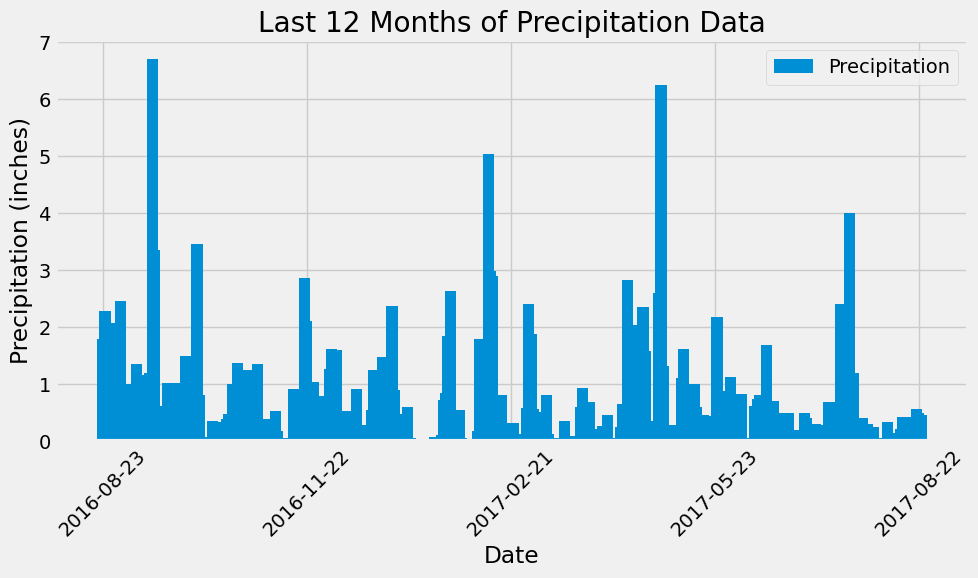

In [10]:
# Calculate the date 12 months prior to the most recent date
end_date = most_recent_date
start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=365)).strftime('%Y-%m-%d')

# Calculate the number of days between the start and end date
num_days = (datetime.strptime(end_date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')).days

# Calculate the step size to evenly divide the last 12 months into 5 intervals
step_size = num_days // 4  # Divide into 5 intervals, including the start and end dates

# Generate 5 evenly spaced dates as strings
evenly_spaced_dates = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i*step_size)).strftime('%Y-%m-%d') for i in range(5)]

# Query precipitation data for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date).all()

# Create a DataFrame from the query results
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Plot the precipitation data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation', width=5)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Last 12 Months of Precipitation Data")
plt.xticks(evenly_spaced_dates, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()

# Create a summary statistics DataFrame
summary_stats_df = pd.DataFrame(summary_stats, columns=['Precipitation'])

summary_stats_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
# Query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Display the stations and their counts in descending order
for station, count in most_active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]  # Extract the station ID of the most active station

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Extract the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Print the results
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp:.2f} °F")

Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


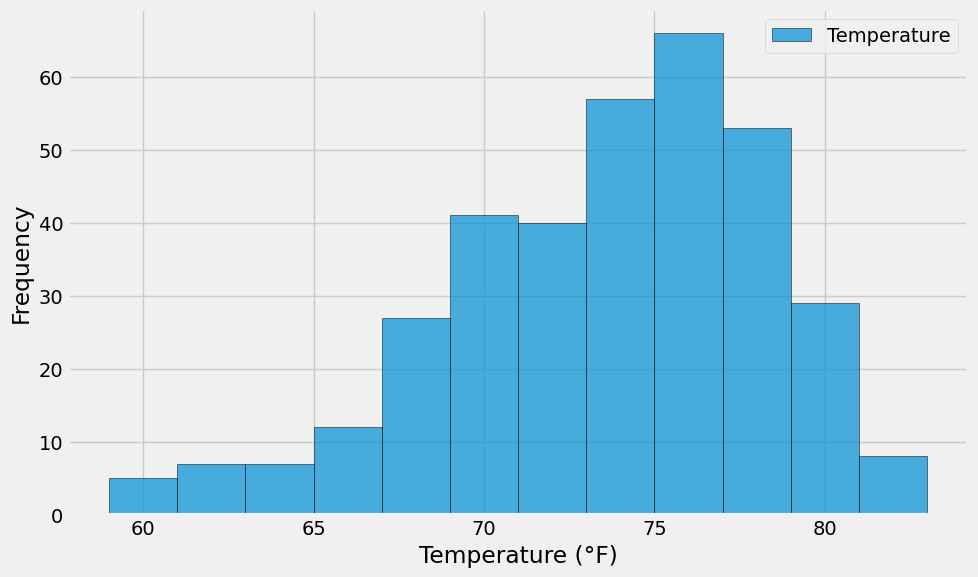

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
end_date = most_recent_date
start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=365)).strftime('%Y-%m-%d')

# Query temperature observations (tobs) for the most active station within the last 12 months
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date).all()

# Create a DataFrame from the query results
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature (°F)'])

# Plot the temperature data as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature (°F)'], bins=12, label='Temperature', alpha=0.7, edgecolor='black')
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()